# Integration of Value, Momentum, Pair Trading

Part of code in this notebook, momentum and pair trading, are based on lecture material from APS1051 Portfolio Management course from University of Toronto from Prof. Sabatino Costanzo and Prof. Loren Trigo. Course information can be accessed: https://gradstudies.engineering.utoronto.ca/files/2018/08/PORTFOLIO_MANAGEMENT_COURSE_SYLLABUS_D.pdf

# Constraints: 

1. Long only; 
2. Purchase integer number of stock;
3. Assuming no transaction fee considered during trading; 
4. Cash account in portfolio always positive; 

In [1]:
## All libraries 

import matplotlib.pylab as plt
import numpy as np
from numpy import log, sqrt

import pandas as pd
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

pd.core.common.is_list_like = pd.api.types.is_list_like 

from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override() 

from scipy.stats.stats import pearsonr
from matplotlib import pyplot
import statsmodels.api as sm

from mpl_toolkits.mplot3d import Axes3D

import sqlite3 as db
import itertools as it

C:\Users\Claire\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Value

Time range: 2011.01.01 - 2016.01.01

Purchase_value = Weight * TOT_PortfolioVal; 
Volumn = Purchase_value / Adj_Close	     [Approximate]

Calculate unit value portfolio;     -> portfolio value change %

In [2]:
df_AAPL=pd.read_csv('AAPL.csv', parse_dates=['Date']).sort_values(by='Date')
df_MSFT=pd.read_csv('MSFT.csv', parse_dates=['Date']).sort_values(by='Date')
df_AAPL.set_index('Date', inplace = True)
df_MSFT.set_index('Date', inplace = True)

In [3]:
# data of AAPL
df_AAPL.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,46.520000,47.180000,46.405716,47.081429,31.528688,111284600
2011-01-04,47.491428,47.500000,46.878571,47.327145,31.693233,77270200
2011-01-05,47.078571,47.762856,47.071430,47.714287,31.952478,63879900
2011-01-06,47.817142,47.892857,47.557144,47.675713,31.926651,75107200
2011-01-07,47.712856,48.049999,47.414288,48.017143,32.155293,77982800


In [4]:
# data of TSLA
df_MSFT.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-01-03,28.049999,28.18,27.920000,27.98,22.814135,53443800
2011-01-04,27.940001,28.17,27.850000,28.09,22.903831,54405600
2011-01-05,27.900000,28.01,27.770000,28.00,22.830442,58998700
2011-01-06,28.040001,28.85,27.860001,28.82,23.499050,88026300
2011-01-07,28.639999,28.74,28.250000,28.60,23.319666,73762000


In [5]:
df_value = 0.5* ((df_AAPL[['Adj Close']] - df_AAPL[['Adj Close']].shift(1))/df_AAPL[['Adj Close']].shift(1)) + 0.5*((df_MSFT[['Adj Close']] - df_MSFT[['Adj Close']].shift(1))/df_MSFT[['Adj Close']].shift(1))

df_value.columns = ['port_rets']
df_value['port_rets'][0] = 0


df_value = df_value.assign(I =np.cumprod(1+df_value['port_rets'])) #this is good for pct return or log return
df_value.iat[0,df_value.columns.get_loc('I')]= 1

start_val = 1
end_val = df_value['I'].iat[-1]

df_value.head()

,port_rets,I
Date,,
2011-01-03,0.000000,1.000000
2011-01-04,0.004575,1.004575
2011-01-05,0.002488,1.007074
2011-01-06,0.014239,1.021414
2011-01-07,-0.000236,1.021173


In [41]:
df_value['I'].iat[-1] - 1

1.8288055131739491

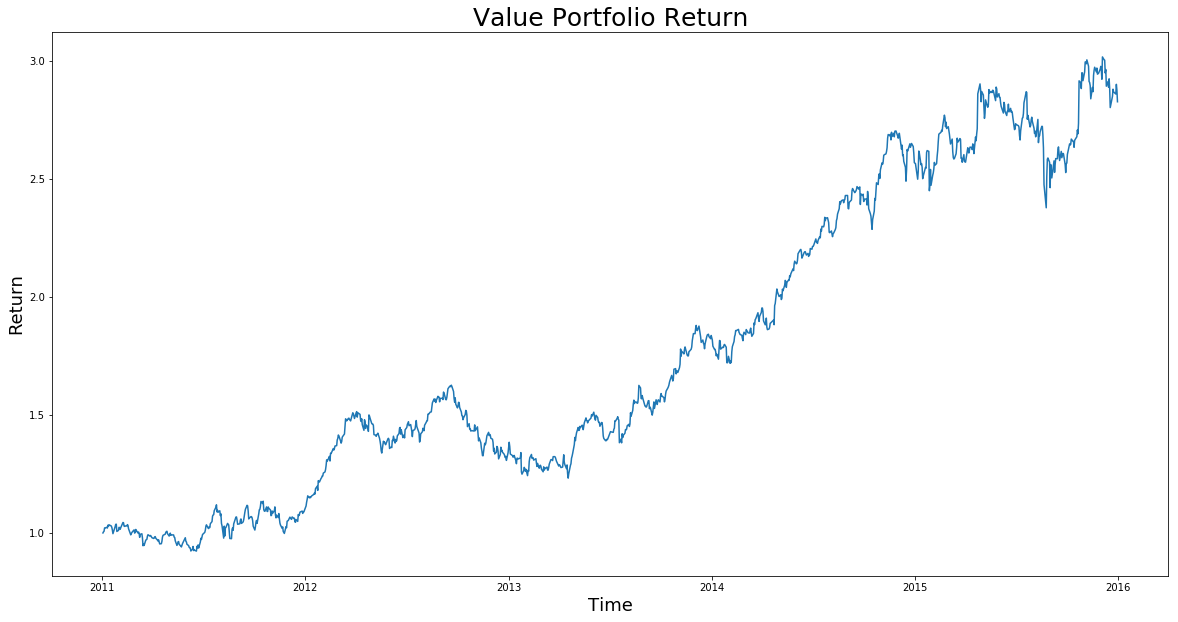

In [6]:
plt.figure(figsize=(20,10))
plt.plot(df_value['I'])
plt.xlabel('Time', fontsize=18)
plt.ylabel('Return', fontsize=18)
plt.title('Value Portfolio Return', fontsize=25)
plt.show()

In [7]:
print('Value Portfolio Return Std: ',round(pd.rolling_std(df_value['I'], 1258)[-1],2))

Value Portfolio Return Std:  0.64


C:\Users\Claire\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1258,center=False).std()
  """Entry point for launching an IPython kernel.


# Momentum

In [8]:
start_date = '2011-01-01' 
end_date = '2016-01-01' 

symbol = 'SPY' 
msg = "" 
address = symbol + '.csv'

In [9]:
def detrendPrice(series):
    length = len(series)
    x = np.arange(length)
    y = np.array(series.values)
    x_const = sm.add_constant(x) #need to add intercept constant
    model = sm.OLS(y,x_const)
    result = model.fit()

    df = pd.DataFrame(result.params*x_const)
    y_hat = df[0] + df[1]
    resid = y-y_hat
    resid = resid + abs(resid.min() + 1/10*resid.min())
    
    return resid 

In [10]:
try:
    dfP = pdr.get_data_yahoo(symbol, start=start_date, end=end_date)
    dfP.to_csv(address, header = True, index=True, encoding='utf-8')
except Exception:
    msg = "yahoo problem"
    dfP = pd.DataFrame()

dfP = pd.read_csv(address, parse_dates=['Date'])
dfP = dfP.sort_values(by='Date')
dfP.set_index('Date', inplace = True)

[*********************100%***********************]  1 of 1 downloaded


In [11]:
lkback =  [5, 10, 20, 25, 40, 60, 120, 250]
hldays = lkback

res = []
for lookback in lkback:
    for holddays in hldays:
        df_Close_lookback = dfP.Close.shift(lookback)
        df_Close_holddays = dfP.Close.shift(-holddays)
        dfP['ret_lag'] = (dfP.Close-df_Close_lookback)/df_Close_lookback
        dfP['ret_fut'] = (df_Close_holddays-dfP.Close)/dfP.Close
        dfc = dfP[['ret_lag','ret_fut']].dropna()
        idx = None
        if lookback >= holddays: 
            idx = np.array(range(0,len(dfc.ret_lag), holddays))
        else: 
            idx = np.array(range(0,len(dfc.ret_lag), lookback))
        dfc = dfc.ix[idx]
        df = dfc.dropna(inplace=False)
        t, p = pearsonr(df.ret_lag.values, df.ret_fut.values)
        res.append([lookback, holddays,  t, p])

res = pd.DataFrame(res,columns=['lookback','holddays','corr','pvalue'])

# res.sort_values(by="pvalue", inplace=True)
# res = res.reset_index(drop=True)
res.head()
# print (res[res['corr'] >= 0][:20])

C:\Users\Claire\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,lookback,holddays,corr,pvalue
0,5,5,-0.244234,0.000096
1,5,10,-0.188591,0.002810
2,5,20,-0.137419,0.030850
3,5,25,-0.219423,0.000528
4,5,40,-0.129459,0.043785


In [12]:
#buy (sell) the asset if it has a positive (negative) 12-month return (assuming that 1 year is the lookback), and hold the
#position for 1 month (=20 trading days, assuming that 1 month is the holding) (similar to Moskowitz, Yao, and Pedersen, 2012). We will modify
#one detail of the original strategy: Instead of making a trading decision every
#month (assuming that is the holding), we will make it every day, each day investing only one twentieth 
#of the total capital. Also, we commented out the shorts.

def trade(df,lookback,holddays):
    
    df["longs"] = (df.Close > df.Close.shift(lookback))
    df["shorts"] = (df.Close < df.Close.shift(lookback)) 
    
    df['pos'] = 0.
    for h in range(holddays):
        df["long_lag"] = df["longs"].shift(h).fillna(False)
        df["short_lag"]= df["shorts"].shift(h).fillna(False)
        df.loc[df["long_lag"],'pos'] += 1
        #df.loc[df["short_lag"],'pos'] -= 1 # no shorts
    
    ret=(df.pos.shift(1)* (df.Close-df.Close.shift(1)) / df.Close.shift(1))/ holddays
    sharpe = np.sqrt(360.)*np.mean(ret)/np.std(ret)
    
#     cumret=np.cumprod(1+ret)-1

#     print ('APR: AnnualPercentageRate in %')
#     print ((((np.prod(1.+ret))**(360./len(ret)))-1)*100)
#     print ('Sharpe')
#     print (np.sqrt(360.)*np.mean(ret)/np.std(ret))
    
    return df,sharpe

In [13]:
#returns must be detrended by subtracting the average daily return of the benchmark
def bootstrap(ser):
    ser.dropna(inplace=True)
    arr = np.array(ser.values)
    alpha = .05*100 #significance alpha
    reps = 5000 #how many bootstrapings, 50000 limit if you have 8GB RAM

    percentile = 100-alpha
    ave = np.average(arr) #arithmetic mean

#     print("average return %f" %ave)

    centered_arr = arr-ave
    n = len(centered_arr)
    #constructs 50000 alternative return histories and calculates their theoretical averages
    xb = np.random.choice(centered_arr, (n, reps), replace=True)
    mb = xb.mean(axis=0) #arithmetic mean
    #mb = ms.gmean(mb, axis=0) #geometric mean

    #sorts the 50000 averages
    mb.sort()
    #calculates the 95% conficence interval (two tails) threshold for the theoretical averages
#     print(np.percentile(mb, [2.5, 97.5])) 
    threshold = np.percentile(mb, [percentile])[0]


#     if ave > threshold:
#         print("Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)")
#     else:
#         print("Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)")


    #count will be the items i that are smaller than ave
    count_vals = 0
    for i in mb:
        count_vals += 1
        if i > ave:
            break
        
    #p is based on the count that are larger than ave so 1-count is needed:
    p = 1-count_vals/len(mb)

    return p

In [14]:
df_output = pd.DataFrame(index = range(0,64), columns = ['Lookback_period','hold_period','sharpe','p_value'])
i=0

for look in lkback:
    for hold in hldays:
        df_output['Lookback_period'][i] = look
        df_output['hold_period'][i] = hold

        
        df_result, sharpe_ratio = trade(dfP,look,hold)
        
        #Detrend prices before calculating detrended returns
        df_result['DetClose'] = detrendPrice(df_result.Close).values
        df_result['DetRet']=(df_result.pos.shift(1)*(df_result.DetClose-df_result.DetClose.shift(1)) / df_result.DetClose.shift(1))/ holddays
        df_result['DetCumret']=np.cumprod(1+df_result.DetRet)-1
        
        df_output['sharpe'][i] = round(sharpe_ratio,3)
        df_output['p_value'][i] = round(bootstrap(dfP.DetRet),3)
        i += 1

df_output.head(10)

,Lookback_period,hold_period,sharpe,p_value
0,5,5,0.014,0.872
1,5,10,0.368,0.488
2,5,20,0.608,0.227
3,5,25,0.523,0.237
4,5,40,0.663,0.177
5,5,60,0.748,0.158
6,5,120,0.809,0.125
7,5,250,0.951,0.094
8,10,5,0.136,0.889
9,10,10,0.384,0.559


In [15]:
df_Sig = df_output[df_output['p_value']<0.05]
df_Sig.head()

,Lookback_period,hold_period,sharpe,p_value


In [16]:
df_output.sort_values(by=['p_value']).head()

,Lookback_period,hold_period,sharpe,p_value
7,5,250,0.951,0.094
15,10,250,0.966,0.097
23,20,250,0.96,0.108
31,25,250,0.947,0.109
54,120,120,0.971,0.111


In [17]:
df_output.sort_values(by=['sharpe'], ascending=False).head()

,Lookback_period,hold_period,sharpe,p_value
48,120,5,1.056,0.259
57,250,10,1.018,0.201
56,250,5,0.999,0.263
39,40,250,0.986,0.115
55,120,250,0.982,0.112


In [18]:
# pick lookback as 125, hold period as 175
df_result, sharpe_ratio = trade(dfP,100,120)
        
#Detrend prices before calculating detrended returns
df_result['DetClose'] = detrendPrice(df_result.Close).values
df_result['DetRet']=(df_result.pos.shift(1)*(df_result.DetClose-df_result.DetClose.shift(1)) / df_result.DetClose.shift(1))/ holddays
df_result['DetCumret']=np.cumprod(1+df_result.DetRet)-1

df_result = df_result.assign(I =np.cumprod(1+df_result['DetRet'])) #this is good for pct return or log return
df_result.iat[0,df_result.columns.get_loc('I')]= 1

start_val = 1
end_val = df_result['I'].iat[-1]

df_result.tail()

,Open,High,Low,Close,Adj Close,Volume,ret_lag,ret_fut,longs,shorts,pos,long_lag,short_lag,DetClose,DetRet,DetCumret,I
Date,,,,,,,,,,,,,,,,,
2015-12-24,205.720001,206.330002,205.419998,205.679993,194.966171,48542200,-0.014565,NaN,False,True,31.0,False,True,15.084450,-0.003493,1.219187,2.219187
2015-12-28,204.860001,205.259995,203.940002,205.210007,194.520630,64967100,-0.011513,NaN,False,True,31.0,False,True,14.531327,-0.004547,1.209097,2.209097
2015-12-29,206.509995,207.789993,206.470001,207.399994,196.596542,92640700,0.009049,NaN,False,True,31.0,False,True,16.638178,0.017978,1.248813,2.248813
2015-12-30,207.110001,207.210007,205.759995,205.929993,195.203140,63317700,0.002434,NaN,False,True,31.0,False,True,15.085041,-0.011575,1.222782,2.222782
2015-12-31,205.130005,205.889999,203.869995,203.869995,193.250412,114877900,0.010658,NaN,False,True,31.0,True,False,12.941907,-0.017617,1.183624,2.183624


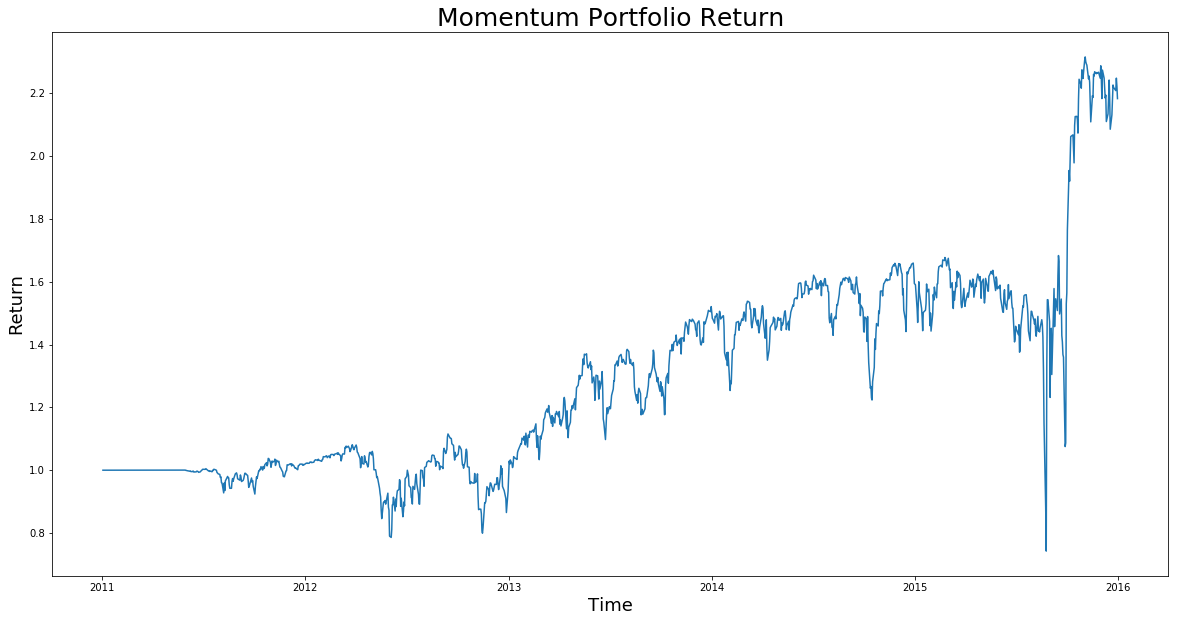

In [19]:
df_mom = df_result

plt.figure(figsize=(20,10))
plt.plot(df_mom['I'])
plt.xlabel('Time', fontsize=18)
plt.ylabel('Return', fontsize=18)
plt.title('Momentum Portfolio Return', fontsize=25)
plt.show()

In [43]:
df_mom['I'][-1]-1

1.1836241668916578

In [20]:
print('Momentum Portfolio Return std: ',round(pd.rolling_std(df_mom['I'], 1258)[-1],2))

Momentum Portfolio Return std:  0.32


C:\Users\Claire\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1258,center=False).std()
  """Entry point for launching an IPython kernel.


# Pair-Trading

In [ ]:
def backtest(symbList, whichfirst, df, row):
    global msg
    
    entryZscore = -1 
    exitZscore = -1 
    window =  7
    regression = 1
    residuals_model = 0
    
    start_date = '2011-01-01' 
    end_date = '2016-01-01'
  
    try:
        y = pdr.get_data_yahoo(symbList[0], start=start_date, end=end_date)
        y.to_csv(symbList[0] + '.csv', header = True, index=True, encoding='utf-8')
        x = pdr.get_data_yahoo(symbList[1], start=start_date, end=end_date)
        x.to_csv(symbList[1] + '.csv', header = True, index=True, encoding='utf-8')
    except Exception:
        msg = "yahoo problem"
        y = pd.DataFrame()
        x = pd.DataFrame()
        df.iloc[row] = np.NaN
        return df

        y = pd.read_csv(symbList[0] + '.csv', parse_dates=['Date'])
        y = y.sort_values(by='Date')
        y.set_index('Date', inplace = True)
        x = pd.read_csv(symbList[1] + '.csv', parse_dates=['Date'])
        x = x.sort_values(by='Date')
        x.set_index('Date', inplace = True)


    if y.index[0] == datetime.strptime('Jan 03 00:00:00 2011', '%b %d %H:%M:%S %Y') and x.index[0] == datetime.strptime('Jan 03 00:00:00 2011', '%b %d %H:%M:%S %Y'): 
        #doing an inner join to make sure dates coincide and there are no NaNs
        #inner join requires distinct column names
        y.rename(columns={'Open':'y_Open','High':'y_High','Low':'y_Low','Close':'y_Close','Adj Close':'y_Adj_Close','Volume':'y_Volume'}, inplace=True) 
        x.rename(columns={'Open':'x_Open','High':'x_High','Low':'x_Low','Close':'x_Close','Adj Close':'x_Adj_Close','Volume':'x_Volume'}, inplace=True) 
        df1 = pd.merge(x, y, left_index=True, right_index=True, how='inner') #inner join


        #get rid of extra columns but keep the date index
        df1.drop(['x_Open', 'x_High','x_Low','x_Close','x_Volume','y_Open', 'y_High','y_Low','y_Close','y_Volume'], axis=1, inplace=True)
        df1.rename(columns={'y_Adj_Close':'y','x_Adj_Close':'x'}, inplace=True) 
        df1 = df1.assign(TIME = pd.Series(np.arange(df1.shape[0])).values) 

        #find the hedge ratio and the spread
        #regress the y variable against the x variable
        #the slope of the rolling linear univariate regression=the rolling hedge ratio

        window_hr_reg = 58 #smallest window for regression when using y_hat
        a = np.array([np.nan] * len(df1))
        b = [np.nan] * len(df1)  # If betas required.
        y_ = df1["y"].values
        x_ = df1[['x']].assign(constant=1).values
        for n in range(window_hr_reg, len(df1)):
            y = y_[(n - window_hr_reg):n]
            X = x_[(n - window_hr_reg):n]
            # betas = Inverse(X'.X).X'.y
            betas = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
            y_hat = betas.dot(x_[n, :])
            a[n] = y_hat
            b[n] = betas.tolist()  # If betas required. b[n][0] is the slope, b[n][1] is the intercept

        if residuals_model:
            myList = []
            for e in range(len(b)):
                if e < window_hr_reg:
                     myList.append(0)
                else:
                    myList.append(b[e][0])
            df1["rolling_hedge_ratio"] = myList
        else:
            df1 = df1.assign(rolling_hedge_ratio = pd.Series(np.ones(df1.shape[0])).values)

        df1["portfolio_cost"]=df1.x*np.abs(df1["rolling_hedge_ratio"])+df1.y

        #calculate the spread
        if residuals_model == 1:
            df1['spread'] = df1.y - df1.rolling_hedge_ratio*df1.x
        else:
            df1['spread'] = log(df1.x) - log(df1.y)

        #rolling regression instead of moving average
        a = np.array([np.nan] * len(df1))
        b = [np.nan] * len(df1)  # If betas required.
        y_ = df1['spread'].values
        x_ = df1[['TIME']].assign(constant=1).values
        for n in range(window, len(df1)):
            y = y_[(n - window):n]
            X = x_[(n - window):n]
            # betas = Inverse(X'.X).X'.y
            betas = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
            y_hat = betas.dot(x_[n, :])
            a[n] = y_hat
            b[n] = betas.tolist()  # If betas required. b[n][0] is the slope, b[n][1] is the intercept

        df1 = df1.assign(y_hat = pd.Series(a).values)

        if regression == 1:
            mean = df1['y_hat']
        else:
            mean = df1['spread'].rolling(window=window).mean()

        #calculate the zScore indicator
        df1 = df1.assign(meanSpread = pd.Series(a).values)
        stdSpread = df1.spread.rolling(window=window).std()
        df1['zScore'] = (df1.spread-mean)/stdSpread


        #set up num units long             
        df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
        df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore)) 
        df1['num units long'] = np.nan 
        df1.loc[df1['long entry'],'num units long'] = 1 
        df1.loc[df1['long exit'],'num units long'] = 0 
        df1.iat[0,df1.columns.get_loc("num units long")]= 0

        df1['num units long'] = df1['num units long'].fillna(method='pad') 

        #set up num units short 
        df1['short entry'] = ((df1.zScore >  entryZscore) & ( df1.zScore.shift(1) < entryZscore))
        df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
        df1['num units short'] = np.nan
        df1.loc[df1['short entry'],'num units short'] = -1 
        df1.loc[df1['short exit'],'num units short'] = 0
        df1.iat[0,df1.columns.get_loc("num units short")]= 0
        df1['num units short'] = df1['num units short'].fillna(method='pad')

        df1['numUnits'] = df1['num units long'] + df1['num units short']
        df1['real_spread'] = df1.x - df1.y
        df1['spread_return'] = (df1['real_spread']-df1['real_spread'].shift(1))/df1.portfolio_cost.shift(1)
        df1['port_rets'] = df1['spread_return'] * df1['numUnits'].shift(1)


        df1 = df1.assign(I =np.cumprod(1+df1['port_rets'])) #this is good for pct return or log return
        df1.iat[0,df1.columns.get_loc('I')]= 1

        start_val = 1
        end_val = df1['I'].iat[-1]

        start_date = df1.iloc[0].name
        end_date = df1.iloc[-1].name
        days = (end_date - start_date).days

        TotaAnnReturn = (end_val-start_val)/start_val/(days/360)
        TotaAnnReturn_trading = (end_val-start_val)/start_val/(days/252)


        try:
            sharpe =  TotaAnnReturn_trading/( (df1['port_rets'].std()) * sqrt(252))
        except ZeroDivisionError:
            sharpe = 0.0

        TotaAnnReturn = TotaAnnReturn*100
        Sharpe = round(sharpe,2)
        df['TotaAnnReturn'][row] = TotaAnnReturn
        df['Sharpe'][row] = Sharpe
        df['p_value'][row] = round(bootstrap(df1.port_rets),3)
        df['Asset1'][row] = symbList[0]
        df['Asset2'][row] = symbList[1]

    else:
        df.iloc[row] = np.NaN
    
    return df

In [ ]:
database='C:\\Users\Claire\Desktop\PythonData.db'

sql = 'SELECT Ticker FROM etftable WHERE "Category" = "Energy";'

In [ ]:
#create a connection to the database specified above
cnx = db.connect(database)
cur = cnx.cursor()
 
#execute the SQL statement and place the results into a 
#variable called "tickers"
tickers = pd.read_sql(sql, con=cnx)
 
#create an empty list
symbList = []
 
#iterate over the DataFrame and append each item into the empty list
for i in range(len(tickers)):
    symbList.append(tickers.ix[i][0])


symbList = list(set(symbList))

#get sumbol pairs
symbPairs = list(it.combinations(symbList, 2))
test_data = symbPairs

In [ ]:
r = []
msg = ""

df_result_yfirst = pd.DataFrame(index = range(0,len(test_data)), columns = ['Asset1', 'Asset2', 'TotaAnnReturn', 'Sharpe','p_value'])

n = 0
for i in test_data:
    df_final_yfirst = backtest(i,"yfirst", df_result_yfirst, n)
    n += 1

In [ ]:
df_final_filtered = df_final_yfirst[df_final_yfirst['p_value']<0.05]
df_final_filtered.sort_values(by=['TotaAnnReturn','Sharpe'], ascending=[0, 0]).reset_index(drop = True)

In [21]:
def backtest2(symbList):
    global msg
    
    entryZscore = -1 
    exitZscore = -1 
    window =  7
    regression = 1
    residuals_model = 0
    
    start_date = '2011-01-01' 
    end_date = '2016-01-01'  
  
    try:
        y = pdr.get_data_yahoo(symbList[0], start=start_date, end=end_date)
        y.to_csv(symbList[0] + '.csv', header = True, index=True, encoding='utf-8')
        x = pdr.get_data_yahoo(symbList[1], start=start_date, end=end_date)
        x.to_csv(symbList[1] + '.csv', header = True, index=True, encoding='utf-8')
    except Exception:
        msg = "yahoo problem"
        y = pd.DataFrame()
        x = pd.DataFrame()
        return 0
    
    y = pd.read_csv(symbList[0] + '.csv', parse_dates=['Date'])
    y = y.sort_values(by='Date')
    y.set_index('Date', inplace = True)
    x = pd.read_csv(symbList[1] + '.csv', parse_dates=['Date'])
    x = x.sort_values(by='Date')
    x.set_index('Date', inplace = True)
     
    #doing an inner join to make sure dates coincide and there are no NaNs
    #inner join requires distinct column names
    y.rename(columns={'Open':'y_Open','High':'y_High','Low':'y_Low','Close':'y_Close','Adj Close':'y_Adj_Close','Volume':'y_Volume'}, inplace=True) 
    x.rename(columns={'Open':'x_Open','High':'x_High','Low':'x_Low','Close':'x_Close','Adj Close':'x_Adj_Close','Volume':'x_Volume'}, inplace=True) 
    df1 = pd.merge(x, y, left_index=True, right_index=True, how='inner') #inner join
    
    
    #get rid of extra columns but keep the date index
    df1.drop(['x_Open', 'x_High','x_Low','x_Close','x_Volume','y_Open', 'y_High','y_Low','y_Close','y_Volume'], axis=1, inplace=True)
    df1.rename(columns={'y_Adj_Close':'y','x_Adj_Close':'x'}, inplace=True) 
    df1 = df1.assign(TIME = pd.Series(np.arange(df1.shape[0])).values) 

    #find the hedge ratio and the spread
    #regress the y variable against the x variable
    #the slope of the rolling linear univariate regression=the rolling hedge ratio
    
    window_hr_reg = 58 #smallest window for regression when using y_hat
    a = np.array([np.nan] * len(df1))
    b = [np.nan] * len(df1)  # If betas required.
    y_ = df1["y"].values
    x_ = df1[['x']].assign(constant=1).values
    for n in range(window_hr_reg, len(df1)):
        y = y_[(n - window_hr_reg):n]
        X = x_[(n - window_hr_reg):n]
        # betas = Inverse(X'.X).X'.y
        betas = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        y_hat = betas.dot(x_[n, :])
        a[n] = y_hat
        b[n] = betas.tolist()  # If betas required. b[n][0] is the slope, b[n][1] is the intercept
    
    if residuals_model:
        myList = []
        for e in range(len(b)):
            if e < window_hr_reg:
                 myList.append(0)
            else:
                myList.append(b[e][0])
        df1["rolling_hedge_ratio"] = myList
    else:
        df1 = df1.assign(rolling_hedge_ratio = pd.Series(np.ones(df1.shape[0])).values)
    
    df1["portfolio_cost"]=df1.x*np.abs(df1["rolling_hedge_ratio"])+df1.y
    
    #calculate the spread
    if residuals_model == 1:
        df1['spread'] = df1.y - df1.rolling_hedge_ratio*df1.x
    else:
        df1['spread'] = log(df1.x) - log(df1.y)
    
    #rolling regression instead of moving average
    a = np.array([np.nan] * len(df1))
    b = [np.nan] * len(df1)  # If betas required.
    y_ = df1['spread'].values
    x_ = df1[['TIME']].assign(constant=1).values
    for n in range(window, len(df1)):
        y = y_[(n - window):n]
        X = x_[(n - window):n]
        # betas = Inverse(X'.X).X'.y
        betas = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        y_hat = betas.dot(x_[n, :])
        a[n] = y_hat
        b[n] = betas.tolist()  # If betas required. b[n][0] is the slope, b[n][1] is the intercept
    
    df1 = df1.assign(y_hat = pd.Series(a).values)
        
    if regression == 1:
        mean = df1['y_hat']
    else:
        mean = df1['spread'].rolling(window=window).mean()
    
    #calculate the zScore indicator
    df1 = df1.assign(meanSpread = pd.Series(a).values)
    stdSpread = df1.spread.rolling(window=window).std()
    df1['zScore'] = (df1.spread-mean)/stdSpread
    
    
    #set up num units long             
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1.iat[0,df1.columns.get_loc("num units long")]= 0
    
    df1['num units long'] = df1['num units long'].fillna(method='pad') 
    
    #set up num units short 
    df1['short entry'] = ((df1.zScore >  entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1['num units short'] = np.nan
    df1.loc[df1['short entry'],'num units short'] = -1 
    df1.loc[df1['short exit'],'num units short'] = 0
    df1.iat[0,df1.columns.get_loc("num units short")]= 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')
    
    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['real_spread'] = df1.x - df1.y
    df1['spread_return'] = (df1['real_spread']-df1['real_spread'].shift(1))/df1.portfolio_cost.shift(1)
    df1['port_rets'] = df1['spread_return'] * df1['numUnits'].shift(1)
    

    df1 = df1.assign(I =np.cumprod(1+df1['port_rets'])) #this is good for pct return or log return
    df1.iat[0,df1.columns.get_loc('I')]= 1

    return df1

In [22]:
# choose ('SZO', 'DNO')

df_pair = backtest2(('DNO','SZO'))
df_pair.tail()

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


,x,y,TIME,rolling_hedge_ratio,portfolio_cost,spread,y_hat,meanSpread,zScore,long entry,long exit,num units long,short entry,short exit,num units short,numUnits,real_spread,spread_return,port_rets,I
Date,,,,,,,,,,,,,,,,,,,,
2015-12-24,91.070000,79.519997,1253,1.0,170.589997,0.135620,0.127452,0.127452,0.833512,True,False,1.0,False,False,-1.0,0.0,11.550003,-0.001110,0.00111,5.044434
2015-12-28,93.309998,82.160004,1254,1.0,175.470002,0.127259,0.133523,0.133523,-0.632292,False,False,1.0,False,False,-1.0,0.0,11.149994,-0.002345,-0.00000,5.044434
2015-12-29,91.389999,79.489998,1255,1.0,170.879997,0.139505,0.136707,0.136707,0.261233,False,False,1.0,False,False,-1.0,0.0,11.900001,0.004274,0.00000,5.044434
2015-12-30,93.839996,82.220001,1256,1.0,176.059997,0.132193,0.142237,0.142237,-0.989947,False,False,1.0,False,False,-1.0,0.0,11.619995,-0.001639,-0.00000,5.044434
2015-12-31,91.699997,81.430000,1257,1.0,173.129997,0.118779,0.141615,0.141615,-2.397736,False,False,1.0,False,True,0.0,1.0,10.269997,-0.007668,-0.00000,5.044434


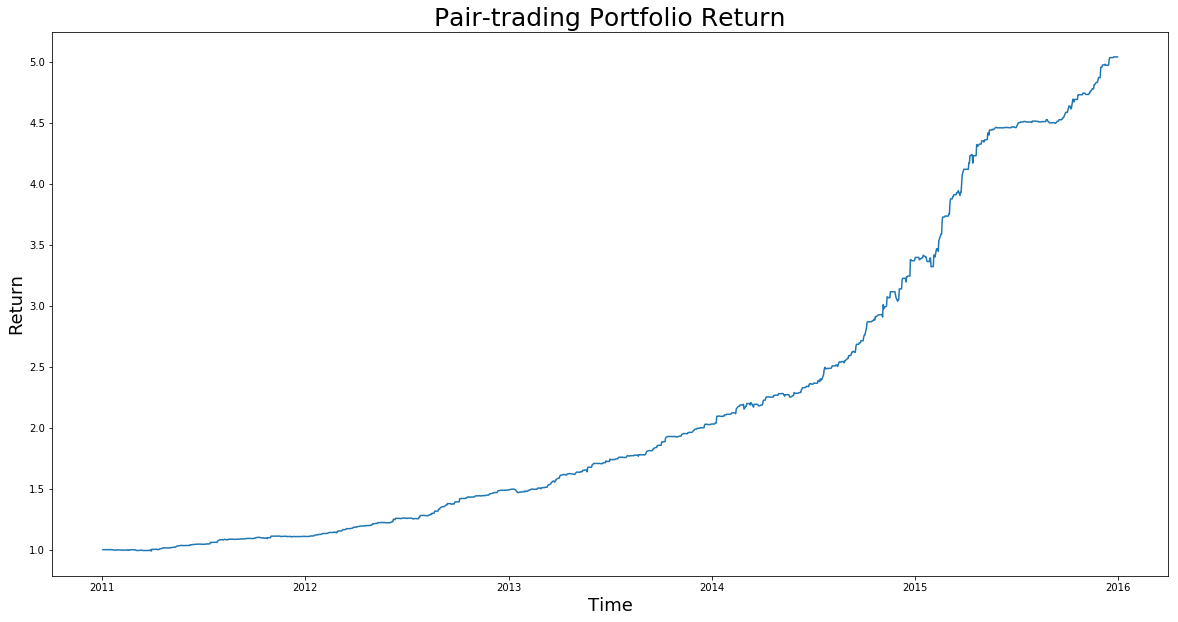

In [23]:
plt.figure(figsize=(20,10))
plt.plot(df_pair['I'])
plt.xlabel('Time', fontsize=18)
plt.ylabel('Return', fontsize=18)
plt.title('Pair-trading Portfolio Return', fontsize=25)
plt.show()

In [44]:
df_pair['I'][-1]-1

4.0444337597982178

In [24]:
print('Pair Portfolio Return std: ',round(pd.rolling_std(df_pair['I'], 1258)[-1],2))

Pair Portfolio Return std:  1.22


C:\Users\Claire\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1258,center=False).std()
  """Entry point for launching an IPython kernel.


# Portfolio Integration

Rebalance: every 4 months; 

Integer number of stocks

In [25]:
TOT_PortfolioVal = 10000

### Method 1: Equal weighted portfolio

In [31]:
# initial purchase happened at time 0

weight_value1 = round(int((TOT_PortfolioVal * 1/3) /(df_MSFT.Close[0]+df_AAPL.Close[0]))*(df_MSFT.Close[0]+df_AAPL.Close[0])/TOT_PortfolioVal,2)
weight_mom1 = round(int((TOT_PortfolioVal * 1/3) /(dfP.Close[0]))*(dfP.Close[0])/TOT_PortfolioVal,2)
weight_pair1 = round(int((TOT_PortfolioVal * 1/3) /(df_pair.portfolio_cost[0]))*(df_pair.portfolio_cost[0])/TOT_PortfolioVal,2) 
weight_cash1 = 1-weight_value1-weight_mom1-weight_pair1
print('Weight for Value: ', weight_value1, "; Weight for Momentum: ", weight_mom1, "; Weight for Pair: ",weight_pair1, '; Cash remaining in the account: ', weight_cash1*TOT_PortfolioVal)

Weight for Value:  0.33 ; Weight for Momentum:  0.33 ; Weight for Pair:  0.33 ; Cash remaining in the account:  100.0


In [35]:
tot_val_1 = df_value['I'].iat[-1] -1
tot_val_2 = df_mom['I'].iat[-1] - 1
tot_val_3 = df_pair['I'].iat[-1] -1

print("Equal Weighted Portfolio Return: ", round(100*(weight_value1 * tot_val_1 + weight_mom1 * tot_val_2 + weight_pair1*tot_val_3),2),'%')

Equal Weighted Portfolio Return:  232.88 %


In [47]:
print('Overall Portfolio Return std: ',round(pd.rolling_std((weight_value1 * df_value['I'] + weight_mom1 * df_mom['I'] + weight_pair1*df_pair['I']), 1258)[1257],2))

Overall Portfolio Return std:  0.7


C:\Users\Claire\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=1258,center=False).std()
  """Entry point for launching an IPython kernel.


### Demo - 

Constant weight over 5 years, ignore integer number of stocks when purchasing

In [ ]:
df_port = pd.DataFrame(index = range(0,1000),columns=['weight_value','weight_momentum','weight_pair', 'port_return', 'Volatility'])  # , 'Volatility'

tot_val_1 = df_value['I'].iat[-1] -1
tot_val_2 = df_mom['I'].iat[-1] - 1
tot_val_3 = df_pair['I'].iat[-1] -1

n = 0
for weight_val in range(0,10,1):
    for weight_momentum in range(0,10,1):
        if 1-weight_momentum/10-weight_val/10 >=0:
            df_port['weight_value'][n] = weight_val/10
            df_port['weight_momentum'][n] = weight_momentum/10
            df_port['weight_pair'][n] = round(1-weight_momentum/10-weight_val/10,1)
            df_port['port_return'][n] = weight_val/10 * tot_val_1 + weight_momentum/10 * tot_val_2 + round(1-weight_momentum/10-weight_val/10,1)*tot_val_3
            df_port['Volatility'][n] = pd.rolling_std(weight_val/10 * df_value['I']+weight_momentum/10 *df_mom['I'] + round(1-weight_momentum/10-weight_val/10,1)* df_pair['I'], 1258)[-1]
            n += 1
        
df_port.sort_values(by=['port_return'], ascending=False).reset_index(drop=True).loc[0]

In [ ]:
df_port.head()

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df_port.Volatility, df_port.port_return, 'o')
plt.show()

### Method 2: rebalance every half months

In [36]:
rebalance_fre_peryear = 24

df_final = pd.DataFrame(index = range(0,int(round(len(df_value)/int(round(len(df_value)/5/rebalance_fre_peryear,0)),0))), columns = ['start_date', 'end_date', 'start_value', 'end_value', 'GainORLoss', 'weight_value', 'weight_mom', 'weight_pair', 'cash_pct','cash'])
period_distance = int(round(len(df_value)/5/rebalance_fre_peryear,0))

# investment strategy: first period: equal weighted; following: max return weights%

def rebalance_port (period_ID, df_port):
    global period_distance
    
    if period_ID ==0:
        start_ID=0
        start_day = df_value.index[start_ID]
        start_value = TOT_PortfolioVal   #initial value
        weight_value = round(int((start_value * 1/3) /(df_MSFT.Close[0]+df_AAPL.Close[0]))*(df_MSFT.Close[0]+df_AAPL.Close[0])/start_value,2)
        weight_mom = round(int((start_value * 1/3) /(dfP.Close[0]))*(dfP.Close[0])/TOT_PortfolioVal,2)
        weight_pair = round(int((start_value * 1/3) /(df_pair.portfolio_cost[0]))*(df_pair.portfolio_cost[0])/TOT_PortfolioVal,2)
        
    else: 
        start_ID= period_distance*(period_ID)+1
        start_day = df_value.index[start_ID] 
        start_value =df_final['end_value'][period_ID-1]

        ret_val_1 = (df_value['I'].iat[start_ID-1] - df_value['I'].iat[start_ID-1-period_distance])/df_value['I'].iat[start_ID-1-period_distance]
        ret_val_2 = (df_mom['I'].iat[start_ID-1] - df_mom['I'].iat[start_ID-1-period_distance])/df_mom['I'].iat[start_ID-1-period_distance]
        ret_val_3 = (df_pair['I'].iat[start_ID-1] - df_pair['I'].iat[start_ID-1-period_distance])/df_pair['I'].iat[start_ID-1-period_distance]

        df_opt = pd.DataFrame(index = range(0,100),columns=['weight_value','weight_momentum','weight_pair', 'port_return'])  # , 'Volatility'
        n = 0
        for weight_val in range(0,10,1):
            for weight_momentum in range(0,10,1):
                if 1-weight_momentum/10-weight_val/10 >=0:
                    df_opt['weight_value'][n] = weight_val/10
                    df_opt['weight_momentum'][n] = weight_momentum/10
                    df_opt['weight_pair'][n] = round(1-weight_momentum/10-weight_val/10,1)
                    df_opt['port_return'][n] = weight_val/10 * ret_val_1 + weight_momentum/10 * ret_val_2 + round(1-weight_momentum/10-weight_val/10,1)*ret_val_3
                    n += 1

        test_df = df_opt.sort_values(by=['port_return'], ascending=False).reset_index(drop=True).loc[0]

        weight_value = round(int((start_value * test_df['weight_value']) /(df_MSFT.Close[start_ID-1]+df_AAPL.Close[start_ID-1]))*(df_MSFT.Close[start_ID-1]+df_AAPL.Close[start_ID-1])/start_value,2)
        weight_mom = round(int((start_value * test_df['weight_momentum']) /(dfP.Close[start_ID-1]))*(dfP.Close[start_ID-1])/start_value,2)
        weight_pair = round(int((start_value * test_df['weight_pair']) /(df_pair.portfolio_cost[start_ID-1]))*(df_pair.portfolio_cost[start_ID-1])/start_value,2)
        
    df_final['weight_value'][period_ID] = weight_value
    df_final['weight_mom'][period_ID] = weight_mom
    df_final['weight_pair'][period_ID] = weight_pair

    
    end_ID = min(len(df_value)-1,period_distance*(period_ID+1))
    end_day = df_value.index[end_ID] 
    df_port['start_date'][period_ID]= start_day.date()
    df_port['end_date'][period_ID]= end_day.date()
    
    df_port['start_value'][period_ID] = start_value
    
    
    value_return = (df_value['I'].iat[end_ID] - df_value['I'].iat[start_ID]) / df_value['I'].iat[start_ID] * (start_value * weight_value)
    mom_return = (df_mom['I'].iat[end_ID] - df_mom['I'].iat[start_ID]) / df_mom['I'].iat[start_ID] * (start_value * weight_mom)
    pair_return = (df_pair['I'].iat[end_ID] - df_pair['I'].iat[start_ID]) / df_pair['I'].iat[start_ID] * (start_value * weight_pair)
    
    df_port['cash_pct'][period_ID] = round((1 - weight_value-weight_mom-weight_pair),2)
    df_port['cash'][period_ID] = round((1 - weight_value-weight_mom-weight_pair) * start_value,1)
    df_port['end_value'][period_ID] = start_value + value_return + mom_return + pair_return + round((1 - weight_value-weight_mom-weight_pair) * start_value,1)
    
    df_port['GainORLoss'][period_ID] = df_port['end_value'][period_ID] - start_value
    
    return df_port

In [37]:
for i in range(int(round(len(df_value)/int(round(len(df_value)/5/rebalance_fre_peryear,0)),0))):
    df_final = rebalance_port (i, df_final)
df_final

,start_date,end_date,start_value,end_value,GainORLoss,weight_value,weight_mom,weight_pair,cash_pct,cash
0,2011-01-03,2011-01-18,10000,10197.2,197.171,0.33,0.33,0.33,0.01,100
1,2011-01-19,2011-02-01,10197.2,10407.5,210.322,0.89,0.09,0,0.02,203.9
2,2011-02-02,2011-02-15,10407.5,10510.5,103.014,0,0.89,0.1,0.01,104.1
3,2011-02-16,2011-03-02,10510.5,10418.5,-92.0557,0.89,0.09,0,0.02,210.2
4,2011-03-03,2011-03-16,10418.5,10373.8,-44.6534,0,0,1,0,0
5,2011-03-17,2011-03-30,10373.8,10586.2,212.446,0,0.89,0.09,0.02,207.5
6,2011-03-31,2011-04-13,10586.2,10474.8,-111.459,0.9,0,0.1,-0,-0
7,2011-04-14,2011-04-28,10474.8,10718.7,243.884,0,0,0.99,0.01,104.7
8,2011-04-29,2011-05-12,10718.7,10670.8,-47.835,0.9,0,0.09,0.01,107.2
9,2011-05-13,2011-05-26,10670.8,10916.6,245.807,0,0,0.99,0.01,106.7


In [38]:
TOT_ret = round((df_final['end_value'][int(round(len(df_value)/int(round(len(df_value)/5/rebalance_fre_peryear,0)),0))-1] - TOT_PortfolioVal)/TOT_PortfolioVal *100,1)
print('Total portfolio return: ', TOT_ret,'%')

Total portfolio return:  329.5 %


In [39]:
print('Overall Portfolio Return std: ',round(pd.rolling_std(df_final.end_value/TOT_PortfolioVal, 126)[125],2))

Overall Portfolio Return std:  1.0


C:\Users\Claire\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=126,center=False).std()
  """Entry point for launching an IPython kernel.
